In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#UNET implementation
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

#Training UNET
import pandas as pd
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Function to create a directory if it doesn't exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# # Function to load dataset paths for images and masks by matching file IDs
# def load_dataset(path, split=0.2):
#     image_dir = os.path.join(path, "images")
#     mask_dir = os.path.join(path, "masks")

#     # Load all image and mask file paths
#     image_files = sorted(glob(os.path.join(image_dir, "*.png")))
#     mask_files = sorted(glob(os.path.join(mask_dir, "*.png")))

#     # Extract file IDs to match corresponding images and masks
#     image_ids = [os.path.basename(f).split('.')[0] for f in image_files]
#     mask_ids = [os.path.basename(f).split('.')[0] for f in mask_files]

#     # Match images and masks by their file IDs
#     images = []
#     masks = []

#     for img_file, img_id in zip(image_files, image_ids):
#         if img_id in mask_ids:
#             mask_file = os.path.join(mask_dir, img_id + ".png")
#             images.append(img_file)
#             masks.append(mask_file)

#     # Split data into training, validation, and testing sets
#     split_size = int(len(images) * split)
#     train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
#     train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

#     train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)



# def load_dataset(path, split=0.2):
#     images = sorted(glob(os.path.join(path, "images", "*.png")))
#     masks = sorted(glob(os.path.join(path, "masks", "*.png")))

#     split_size = int(len(images) * split)

#     train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
#     train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

#     train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    # Split the data into training and testing sets with the specified ratio
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=split, random_state=43)

    # Optionally, you can further split training data into training and validation sets
    valid_split = split / (1 - split)  # For a balanced valid split from remaining train data
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=valid_split, random_state=43)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Function to read and process an image with error handling
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    if x is None:
        raise ValueError(f"Error loading image: {path}")
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

# Function to read and process a mask with error handling
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if x is None:
        raise ValueError(f"Error loading mask: {path}")
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

# Function to parse the image and mask using TensorFlow operations
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

# Function to create a TensorFlow dataset
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

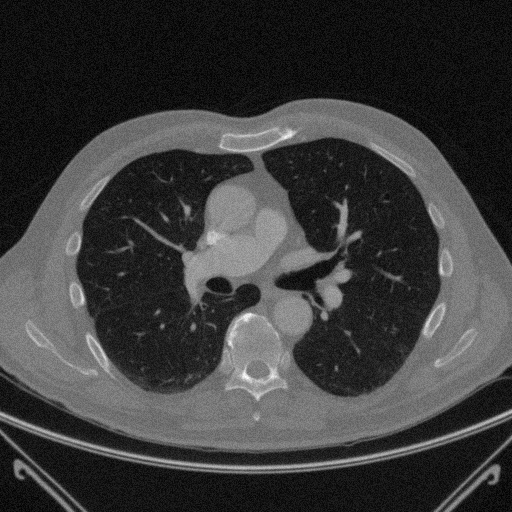

In [ ]:

from PIL import Image
from torchvision.transforms import ToTensor
image = Image.open("/content/drive/MyDrive/images/ID_0000_Z_0142.png")
mask = Image.open("/content/drive/MyDrive/masks/ID_0000_Z_0142.png")
image


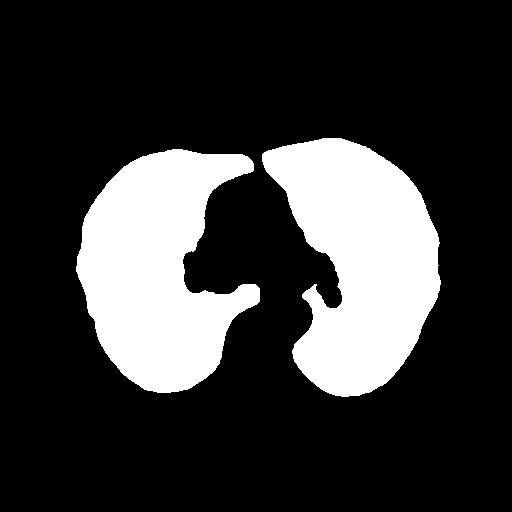

In [ ]:
mask

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=43)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=43)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=43)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=43)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(43)
    tf.random.set_seed(43)

    # Create a directory for storing model files
    create_dir("/content/drive/MyDrive/files")

    batch_size = 16
    lr = 1e-4
    num_epochs = 500
    # model_path = os.path.join("files", "model.h5")
    model_path = os.path.join("/content/drive/MyDrive/files", "model.keras")
    csv_path = os.path.join("/content/drive/MyDrive/files", "log.csv")

    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
        # (train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)


    print(f"Train: {len(train_x)} - {len(train_y)}")
    # print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0 instead.

In [ ]:
# if __name__ == "__main__":
#     shape = (256, 256, 3)
#     model = unet(shape)

#     model.summary()

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# def save_results(image, mask, y_pred, save_image_path):
#     mask = np.expand_dims(mask, axis=-1)
#     mask = np.concatenate([mask, mask, mask], axis=-1)

#     y_pred = np.expand_dims(y_pred, axis=-1)

def save_results(image, mask, y_pred, save_image_path):
    # Convert the ground truth mask to RGB
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    # Convert prediction to RGB and scale to 255
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred_rgb = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255  # Convert to RGB format

    # Create a colored overlay for the predicted mask
    overlay = image.copy()  # Start with the original image
    red_color = (0, 0, 255)  # Red color for the overlay

    # Apply the red overlay to the mask region where prediction is 1
    overlay[y_pred.squeeze() == 1] = red_color  # Squeeze to ensure shape matches

    # Blend original image and the mask (alpha blending)
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)  # 0.7: original, 0.3: mask transparency

    # Concatenate the images (original with overlay, mask, prediction)
    line = np.ones((H, 10, 3)) * 255
    cat_images = np.concatenate([blended, line, mask, line, y_pred_rgb], axis=1)

    # Save the concatenated image
    cv2.imwrite(save_image_path, cat_images)



if __name__ == "__main__":
    """ Seeding """
    np.random.seed(43)
    tf.random.set_seed(43)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/results3")

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/files", "model.keras"))

    """ Dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("/content/drive/MyDrive/results3", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/files/score.csv")

  0%|          | 0/54 [00:01<?, ?it/s]


IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 1

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tqdm import tqdm

""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    # Convert the ground truth mask to RGB for visualization
    mask = np.expand_dims(mask, axis=-1)
    mask_rgb = np.concatenate([mask, mask, mask], axis=-1)

    # Convert prediction to RGB (for visualization purposes) and scale to 255
    y_pred_rgb = np.expand_dims(y_pred, axis=-1)
    y_pred_rgb = np.concatenate([y_pred_rgb, y_pred_rgb, y_pred_rgb], axis=-1) * 255

    # Create a red overlay where the predicted mask is 1
    overlay = image.copy()  # Start with the original image
    red_color = (0, 0, 255)  # Red color for the overlay

    # Apply the red overlay to the mask region where prediction is 1
    overlay[y_pred == 1] = red_color  # Apply red where prediction is 1

    # Blend the original image and the overlay with some transparency
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)  # Alpha blending: 0.7 original, 0.3 overlay

    # Create a white line for separation
    line = np.ones((H, 10, 3)) * 255

    # Concatenate the original + overlay, ground truth mask, and predicted mask side by side
    cat_images = np.concatenate([image, line, mask_rgb, line, y_pred_rgb, line,blended], axis=1)

   # Add labels to the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    color = (255, 255, 255)  # White color for text
    thickness = 1

    # Label positions: choose y=30 (pixels from the top) and various x positions
    cv2.putText(cat_images, "Original Image", (10, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Ground Truth Mask", (H + 20, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Predicted Mask", (2 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Prediction Overlay", (3 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)


    # Save the final concatenated image
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(43)
    tf.random.set_seed(43)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/results3")

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/files", "model.keras"))

    """ Dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # [H, W, 3]
        image = cv2.resize(image, (W, H))        # Resize to [H, W, 3]
        x_input = image / 255.0                  # Normalize to [0, 1]
        x_input = np.expand_dims(x_input, axis=0)  # [1, H, W, 3]

        """ Reading the mask (ground truth) """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))  # Resize to match prediction dimensions

        """ Prediction """
        y_pred = model.predict(x_input, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)  # Remove extra dimension [H, W]
        y_pred = (y_pred >= 0.5).astype(np.int32)  # Threshold to binary mask

        """ Saving the prediction with overlay """
        save_image_path = os.path.join("/content/drive/MyDrive/results3", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the arrays for metric calculations """
        mask_flat = (mask / 255.0).astype(np.int32).flatten()  # Convert mask to binary
        y_pred_flat = y_pred.flatten()  # Flatten predicted mask

        """ Calculate the metrics values """
        f1_value = f1_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary")
        recall_value = recall_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=0)

        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Print metrics """
    score = np.mean([s[1:] for s in SCORE], axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    """ Save scores to CSV """
    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/files/score.csv")


100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


F1: 0.97689
Jaccard: 0.95596
Recall: 0.99206
Precision: 0.96355
